In [10]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [11]:
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')

X_train_full = train_df.drop('smoking', axis=1)
y_train_full = train_df['smoking']
X_test_final = test_df.copy()

print(f"Train: {train_df.shape}, Test: {test_df.shape}")
print(f"Class balance: {y_train_full.value_counts(normalize=True).to_dict()}")

Train: (38984, 23), Test: (16708, 22)
Class balance: {0: 0.6327211163554278, 1: 0.3672788836445721}


In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train_full
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_final)

print(f"Train: {X_train.shape}, Val: {X_val.shape}")

Train: (31187, 22), Val: (7797, 22)


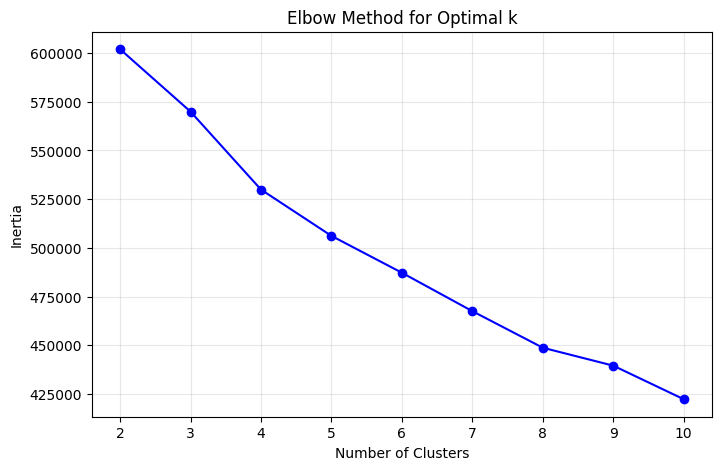

In [13]:
inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans.fit(X_train_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(alpha=0.3)
plt.show()

In [14]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
kmeans.fit(X_train_scaled)

train_clusters = kmeans.predict(X_train_scaled)
cluster_label_mapping = {}

for cluster_id in range(n_clusters):
    cluster_mask = train_clusters == cluster_id
    cluster_labels = y_train[cluster_mask]
    majority_label = cluster_labels.mode()[0]
    cluster_label_mapping[cluster_id] = majority_label
    smoker_pct = (cluster_labels == 1).sum() / len(cluster_labels) * 100
    print(f"Cluster {cluster_id}: {len(cluster_labels)} samples, {smoker_pct:.1f}% smokers → Label: {majority_label}")

print(f"\nCluster to Label Mapping: {cluster_label_mapping}")

Cluster 0: 16764 samples, 54.5% smokers → Label: 1
Cluster 1: 14423 samples, 16.0% smokers → Label: 0

Cluster to Label Mapping: {0: np.int64(1), 1: np.int64(0)}


In [15]:
val_clusters = kmeans.predict(X_val_scaled)
y_val_pred = np.array([cluster_label_mapping[cluster] for cluster in val_clusters])

print(f"Accuracy:  {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred):.4f}")
print(f"Recall:    {recall_score(y_val,y_val_pred):.4f}")
print(f"F1-Score:  {f1_score(y_val, y_val_pred):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=['Non-Smoker', 'Smoker']))

Accuracy:  0.6688
Precision: 0.5334
Recall:    0.7870
F1-Score:  0.6358

Confusion Matrix:
[[2961 1972]
 [ 610 2254]]

Classification Report:
              precision    recall  f1-score   support

  Non-Smoker       0.83      0.60      0.70      4933
      Smoker       0.53      0.79      0.64      2864

    accuracy                           0.67      7797
   macro avg       0.68      0.69      0.67      7797
weighted avg       0.72      0.67      0.67      7797



In [16]:
best_score = 0
best_config = None
results = []

for k in [2, 3, 4]:
    for init_method in ['k-means++', 'random']:
        for n_init_val in [10, 20]:
            for max_iter_val in [300]:
                kmeans_trial = KMeans(
                    n_clusters=k, 
                    init=init_method,
                    n_init=n_init_val, 
                    max_iter=max_iter_val,
                    random_state=RANDOM_STATE
                )
                kmeans_trial.fit(X_train_scaled)
                train_clusters_trial = kmeans_trial.predict(X_train_scaled)
                
                mapping = {}
                for cluster_id in range(k):
                    cluster_mask = train_clusters_trial == cluster_id
                    cluster_labels = y_train[cluster_mask]
                    if len(cluster_labels) > 0:
                        mapping[cluster_id] = cluster_labels.mode()[0]
                    else:
                        mapping[cluster_id] = 0
                
                val_clusters_trial = kmeans_trial.predict(X_val_scaled)
                y_val_pred_trial = np.array([mapping[cluster] for cluster in val_clusters_trial])
                
                accuracy = accuracy_score(y_val, y_val_pred_trial)
                f1 = f1_score(y_val, y_val_pred_trial)
                precision = precision_score(y_val, y_val_pred_trial)
                recall = recall_score(y_val, y_val_pred_trial)
                
                results.append({
                    'k': k, 
                    'init': init_method,
                    'n_init': n_init_val,
                    'max_iter': max_iter_val,
                    'accuracy': accuracy, 
                    'precision': precision, 
                    'recall': recall, 
                    'f1': f1
                })
                
                if f1 > best_score:
                    best_score = f1
                    best_config = {
                        'k': k,
                        'init': init_method,
                        'n_init': n_init_val,
                        'max_iter': max_iter_val
                    }

results_df = pd.DataFrame(results)
print("Hyperparameter Tuning Results:")
print(results_df)
print(f"\nBest Configuration: k={best_config['k']}, init='{best_config['init']}', n_init={best_config['n_init']}, max_iter={best_config['max_iter']} with F1-Score: {best_score:.4f}")

Hyperparameter Tuning Results:
    k       init  n_init  max_iter  accuracy  precision    recall        f1
0   2  k-means++      10       300  0.668847   0.533365  0.787011  0.635825
1   2  k-means++      20       300  0.668462   0.533159  0.783170  0.634422
2   2     random      10       300  0.668847   0.533396  0.786313  0.635620
3   2     random      20       300  0.668847   0.533396  0.786313  0.635620
4   3  k-means++      10       300  0.665769   0.527181  0.873603  0.657556
5   3  k-means++      20       300  0.665769   0.527181  0.873603  0.657556
6   3     random      10       300  0.668847   0.534525  0.762221  0.628382
7   3     random      20       300  0.668847   0.534525  0.762221  0.628382
8   4  k-means++      10       300  0.667051   0.529080  0.851257  0.652570
9   4  k-means++      20       300  0.667051   0.529067  0.851606  0.652663
10  4     random      10       300  0.667051   0.529143  0.849511  0.652104
11  4     random      20       300  0.667308   0.529284  

In [17]:
final_kmeans = KMeans(
    n_clusters=best_config['k'], 
    init=best_config['init'],
    n_init=best_config['n_init'],
    max_iter=best_config['max_iter'],
    random_state=RANDOM_STATE
)
X_train_full_scaled = scaler.fit_transform(X_train_full)
final_kmeans.fit(X_train_full_scaled)

train_full_clusters = final_kmeans.predict(X_train_full_scaled)
final_mapping = {}

for cluster_id in range(best_config['k']):
    cluster_mask = train_full_clusters == cluster_id
    cluster_labels = y_train_full[cluster_mask]
    if len(cluster_labels) > 0:
        final_mapping[cluster_id] = cluster_labels.mode()[0]
    else:
        final_mapping[cluster_id] = 0

val_final_clusters = final_kmeans.predict(X_val_scaled)
y_val_final_pred = np.array([final_mapping[cluster] for cluster in val_final_clusters])

print(f"Final Accuracy:  {accuracy_score(y_val, y_val_final_pred):.4f}")
print(f"Final Precision: {precision_score(y_val, y_val_final_pred):.4f}")
print(f"Final Recall:    {recall_score(y_val, y_val_final_pred):.4f}")
print(f"Final F1-Score:  {f1_score(y_val, y_val_final_pred):.4f}")

Final Accuracy:  0.6677
Final Precision: 0.5335
Final Recall:    0.7584
Final F1-Score:  0.6264


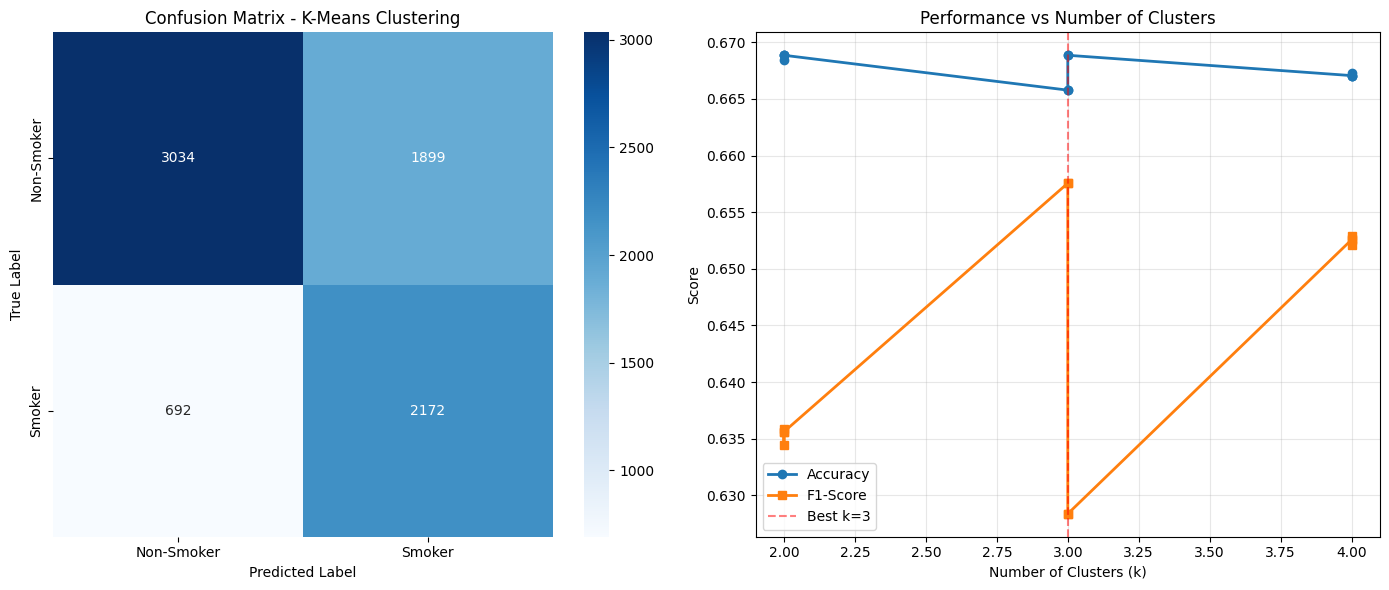

In [18]:
cm = confusion_matrix(y_val, y_val_final_pred)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Smoker', 'Smoker'], yticklabels=['Non-Smoker', 'Smoker'], ax=axes[0])
axes[0].set_title('Confusion Matrix - K-Means Clustering')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

axes[1].plot(results_df['k'], results_df['accuracy'], 'o-', label='Accuracy', linewidth=2)
axes[1].plot(results_df['k'], results_df['f1'], 's-', label='F1-Score', linewidth=2)
axes[1].axvline(best_config['k'], color='red', linestyle='--', alpha=0.5, label=f"Best k={best_config['k']}")
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Score')
axes[1].set_title('Performance vs Number of Clusters')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()